In [266]:
from __future__ import division
from __future__ import print_function
import pandas as pd
%pylab inline
import time
import warnings
import os
from collections import Counter
from itertools import chain
import json
import seaborn as sns
import ast
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
import sklearn.preprocessing

print("Imports done ...✈✈✈✈✈✈✈✈ You are free to go.")
import keras
from keras.layers import Activation,Dense
from keras.models import Sequential
import tensorflow as tf
import six
from sklearn.datasets import load_breast_cancer

Populating the interactive namespace from numpy and matplotlib
Imports done ...✈✈✈✈✈✈✈✈ You are free to go.


/home/cts/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [267]:
dataset_folder = './crowdsignals'
fname = 'chapter5_result.csv'
dataset_path = os.path.join(dataset_folder,fname)
print(dataset_path)
print(os.getcwd())
print(os.listdir(dataset_folder))

./crowdsignals/chapter5_result.csv
/home/cts/Desktop/ML4QS/Assignments/assignments_code_git/assignment2
['chapter3_result_outliers.csv', 'chapter2_result.csv', 'chapter3_result_final.csv', 'chapter4_result.csv', 'chapter5_result.csv']


#### Chapter 6.2
Explore gradient descent and change the learning rate η. What happens to the trajectory of the gradient descent? Is a fast gradient descent always a good idea? (Hint: the answer is No!).


------
In most classification problems, the cost function we want to approximate is highly convex. So to approximate it fast we might need a large learning rate. However this can backfire as the error loss gets bouncing around the downhill slope toward the local minima. An example is illustrated in the picture below. Note that these images are an ideal case for illustrating how the learning rate affects the optimization of our cost function.

<img src="sgd.png">
In addition we show a coding example on the crowdsignal data with a simple MLP implemented in keras to show how sgd learning rate affects training.

In [268]:
def mlp_model(D,nb_classes=10):
    
    model = Sequential()
    input_shape = (D,)
#     print(input_shape,' input dimensions')
    layers = [
        Dense(100,name='fc1',input_shape=input_shape),
        Activation('tanh',name='fc1_act'),
        Dense(20,name='fc2'),
        Activation('tanh',name='fc2_act'),
        Dense(nb_classes,name='fc_out'),
        Activation('softmax',name='output')
    ]
    for layer in layers:
#         print('Added layer:%s'%layer.name)
        model.add(layer)

    return model

def batch_indices(batch_nb, data_length, batch_size):
    """
    This helper function computes a batch start and end index
    :param batch_nb: the batch number
    :param data_length: the total length of the data being parsed by batches
    :param batch_size: the number of inputs in each batch
    :return: pair of (start, end) indices
    """
    # Batch start and end index
    start = int(batch_nb * batch_size)
    end = int((batch_nb + 1) * batch_size)

    # When there are not enough inputs left, we reuse some to complete the
    # batch
    if end > data_length:
        shift = end - data_length
        start -= shift
        end -= shift

    return start, end



def model_eval(sess, x, y, model, X_test, Y_test, args=None):

    
    # Define accuracy symbolically
    correct_preds = tf.equal(tf.argmax(y, axis=tf.rank(y) - 1),
                                 tf.argmax(model, axis=tf.rank(model) - 1))
    acc_value = tf.reduce_mean(tf.to_float(correct_preds))
    
    # Init result var
    accuracy = 0.0
    preds = np.zeros(Y_test.shape[0])
    logits = np.zeros((Y_test.shape[0],2))
    with sess.as_default():

        nb_batches = int(math.ceil(float(len(X_test)) / args['batch_size']))

        for batch in range(nb_batches):

            start = batch * args['batch_size']
            end = min(len(X_test), start + args['batch_size'])
            cur_batch_size = end - start

            cur_acc, cur_preds,cur_logits  = sess.run([acc_value, correct_preds,model],
                                          feed_dict={x: X_test[start:end],
                                                     y: Y_test[start:end]})
            accuracy += (cur_batch_size * cur_acc)
            preds[start:end, ] = cur_preds
            logits[start:end,:] = cur_logits

        # Divide by number of examples to get final value
        accuracy /= len(X_test)

    return accuracy, preds ,logits

def model_train(sess, x, y, predictions, X_train, Y_train,args=None,verbose=True, init_all=True):
    
    loss = model_loss(y, predictions)
    
    train_step = tf.train.GradientDescentOptimizer(learning_rate=args['learning_rate']).minimize(loss)
    losses = []
    with sess.as_default():
        if hasattr(tf, "global_variables_initializer"):
            if init_all:
                tf.global_variables_initializer().run()
        prev = time.time()
        
        for epoch in six.moves.xrange(args['nb_epochs']):
            
            nb_batches = int(math.ceil(float(len(X_train)) / args['batch_size']))
            epoch_loss = 0.0
            for batch in range(nb_batches):
                start, end = batch_indices(batch, len(X_train), args['batch_size'])
                cur_loss,_ =  sess.run([loss,train_step],feed_dict={x: X_train[start:end],
                                          y: Y_train[start:end]})
                cur_loss /= args['batch_size']
                epoch_loss += cur_loss
            epoch_loss /= nb_batches
            
            if epoch % 100 == 0 and verbose:
                
                print("Epoch %d/%d took %s seconds,\t average loss is :%e"
                        %(epoch+1,args['nb_epochs'], str(time.time() - prev),epoch_loss))
                prev = time.time()
                
            losses.append(epoch_loss)
        if verbose:
            print("Epoch %d/%d \t Final loss is %2.8f:"
              %(epoch+1,args['nb_epochs'],losses[-1]))
    return losses
                
def model_loss(y, model, mean=True):

    op = model.op
    if "softmax" in str(op).lower():
        logits, = op.inputs
    else:
        logits = model

    out = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

    if mean:
        out = tf.reduce_mean(out)
    return out

def data_prepare(df_name):
    
    df = pd.read_csv(df_name,index_col=0)
    x_columns = ['acc_phone_x','acc_phone_y','acc_phone_z',
                 'acc_watch_x','acc_watch_y','acc_watch_z',
                 'gyr_phone_x','gyr_phone_y','gyr_phone_z',
                 'hr_watch_rate',
                ]
    y_columns = ['labelOnTable','labelSitting','labelWashingHands',
                 'labelWalking','labelStanding','labelDriving',
                 'labelEating','labelRunning'
                ]
    X = df[x_columns]
    Y = df[y_columns]
    return X,Y

    
   

In [4]:
X,Y = data_prepare(dataset_path)

keras.layers.core.K.set_learning_phase(0)
keras.backend.manual_variable_initialization(True)
# Set TF random seed to improve reproducibility
tf.set_random_seed(42)

sess = tf.Session()
keras.backend.set_session(sess)
classes = np.arange(Y.shape[1])
D = (X.shape[1])
x = tf.placeholder(tf.float32, shape=(None, D))
y = tf.placeholder(tf.float32, shape=(None, len(classes)))
print("Created TensorFlow session and set Keras backend.")
batch_size = 1024
nb_epochs = 1000
learning_rate = 1e-3
train_params = { 
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }

print('Number of classes %d'%len(classes))

model = mlp_model(D,nb_classes=len(classes))
preds = model(x)
losses1 = model_train(sess,x,y,preds,X,Y,args=train_params)
learning_rate = 1
train_params = { 
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
losses2 = model_train(sess,x,y,preds,X,Y,args=train_params)


Created TensorFlow session and set Keras backend.
Number of classes 8
(10,)  input dimensions
Added layer:fc1
Added layer:fc1_act
Added layer:fc2
Added layer:fc2_act
Added layer:fc_out
Added layer:output
Epoch 1/1000 took 0.514413118362 seconds,	 average loss is :0.00139580
Epoch 101/1000 took 0.872133970261 seconds,	 average loss is :0.00109046
Epoch 201/1000 took 1.08349490166 seconds,	 average loss is :0.00104624
Epoch 301/1000 took 0.939881086349 seconds,	 average loss is :0.00101179
Epoch 401/1000 took 0.849519968033 seconds,	 average loss is :0.00097380
Epoch 501/1000 took 0.908658027649 seconds,	 average loss is :0.00095605
Epoch 601/1000 took 0.860600948334 seconds,	 average loss is :0.00094169
Epoch 701/1000 took 0.931313037872 seconds,	 average loss is :0.00093000
Epoch 801/1000 took 0.854562997818 seconds,	 average loss is :0.00092008
Epoch 901/1000 took 0.938071012497 seconds,	 average loss is :0.00091137
Epoch 1000/1000 	 Final loss is 0.00090352:
Epoch 1/1000 took 0.01952

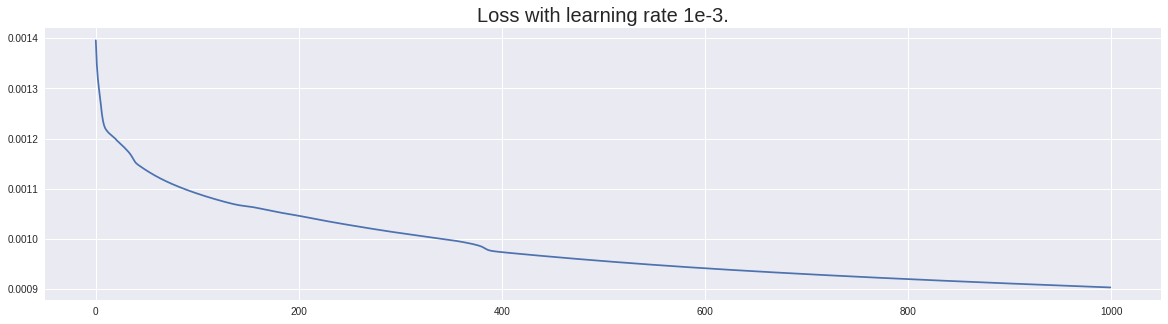

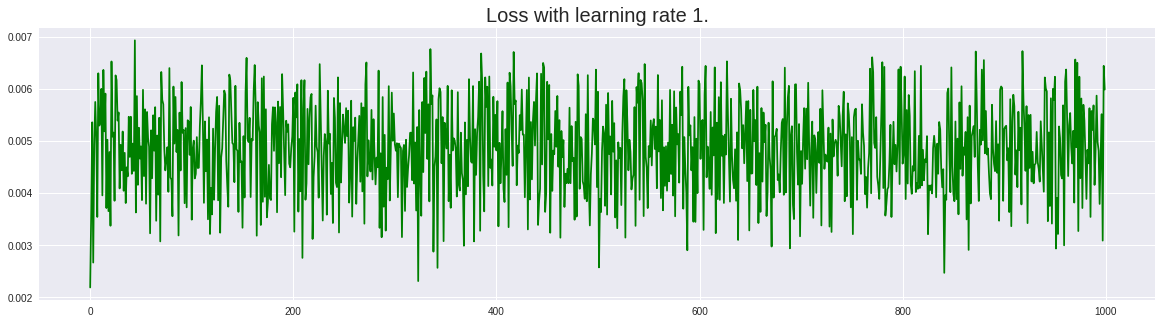

In [6]:
rcParams['figure.figsize'] = (20,5)
plt.plot(losses1);
plt.title('Loss with learning rate 1e-3.',fontsize=20)
plt.savefig('low_rate.png')
plt.show()
plt.plot(losses2,c='g');
plt.title('Loss with learning rate 1.',fontsize=20)
plt.savefig('high_rate.png')
plt.show()


 From the above figures we can see the multiple oscillations the loss function does on the training set. Both training sessions where on an Multilayer perceptron with 2 hidden layers with 100 and 50 neurons respectively. Batch size was fixed at 1024 and epochs where 1000. Both models were trained on the crowdsignals dataset using 
sensors such as accelerometer (phone,watch),gyroscope and heart rate to predict the labels given.

## Chapter 6.3
For answering this question we will be using scikit's breast cancer dataset https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic

In [269]:
def roc_curve(P):
    roc_curve_points = []
    N = P.shape[0]
    pos = np.where(P[:,1]==1)[0].shape[0]
    neg = N-pos
    unique_probs = np.unique(P)
    for p in unique_probs[::-1]:
        P_select = np.where(P[:,0]>=p)[0]
        neg_point = np.where(P[P_select,1]==0)[0].shape[0]/neg
        pos_point = np.where(P[P_select,1]==1)[0].shape[0]/pos
        point = [neg_point,pos_point]
        roc_curve_points.append(point)
    
    return np.array(roc_curve_points)


In [285]:
np.random.seed(42)
tf.set_random_seed(42)
data = load_breast_cancer()
X = data.data
Y = data.target
sess = tf.Session()
keras.backend.set_session(sess)
YY = np.zeros((Y.shape[0],2))
for i,v in enumerate(Y):
    if v == 0:
        YY[i,:] = [1,0]
    else:
        YY[i,:] = [0,1]
Y = YY
print(Y.shape)
D = X.shape[1]
classes =[0,1]
x = tf.placeholder(tf.float32, shape=(None, D))
y = tf.placeholder(tf.float32, shape=(None, len(classes)))
print("Created TensorFlow session and set Keras backend.")
batch_size = 1024
nb_epochs = 500
learning_rate = 1e-3
train_params = { 
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }

print('Number of classes %d'%len(classes))
model = mlp_model(D,nb_classes=len(classes))
preds = model(x)
model_train(sess,x,y,preds,X,Y,args=train_params,verbose=True);


(569, 2)
Created TensorFlow session and set Keras backend.
Number of classes 2
Epoch 1/500 took 0.0815081596375 seconds,	 average loss is :1.477416e-03
Epoch 101/500 took 0.319403886795 seconds,	 average loss is :4.145744e-04
Epoch 201/500 took 0.355571985245 seconds,	 average loss is :3.359015e-04
Epoch 301/500 took 0.325088024139 seconds,	 average loss is :3.019699e-04
Epoch 401/500 took 0.313801050186 seconds,	 average loss is :2.853923e-04
Epoch 500/500 	 Final loss is 0.00028291:


In [286]:
acc,predictions,logits = model_eval(sess,x,y,preds,X,Y,args={'batch_size':batch_size})
indices = logits[:,1] > logits[:,0]

P = np.zeros((len(indices),2))
P[:,0] = np.max(logits,axis=1)
P[:,1] = np.argmax(logits,axis=1)

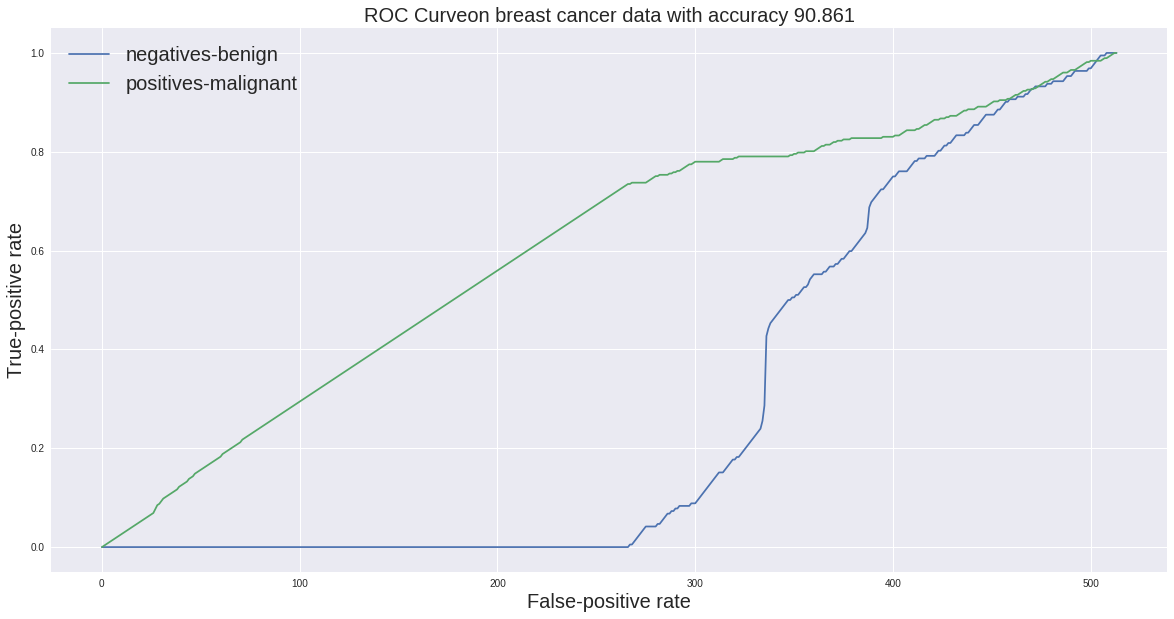

In [287]:
roc_points = roc_curve(P)
rcParams['figure.figsize'] = (20,10)
plt.plot(roc_points)
plt.legend(['negatives-benign','positives-malignant'],fontsize=20)
plt.ylabel('True-positive rate',fontsize=20)
plt.xlabel('False-positive rate',fontsize=20)
plt.title('ROC Curveon breast cancer data with accuracy %.3f'%(acc*100),fontsize=20)
plt.savefig('roc_curve.png')
plt.show()

# Chapter 6.4
When having more features than data points, we are left with having a multiple (sometimes infinite) set of functions as a solution to the empirical risk minimization. This reduces our generalization for the data, causing us to overfit in the training set. In order to avoid this we need to introduce some constraints to our model. Such a constraint is often called regularization, wich introduces a new parameter to the error function so we can penalize the weights of the features in the data. Other models such as SVMs work by default with this parameter, through the introduction of lagrangian multipliers (more constraints). Other methods also for such occasions is by using Maximum Aposteriori methods, which are often used in Bayesian Learning (Penalized Maximum Likelihood). To show a simple example of how regularization affects we ...blah blah